# Some Common Imports

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import segmentation_models_pytorch as smp
from torch import nn
from segmentation_models_pytorch.losses import DiceLoss
from torch.utils.data import DataLoader
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [43]:
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<64>"

In [2]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        

# Task : 2 Setup Configurations

In [44]:
CSV_FILE = 'train.csv'#os.path.join(os.getcwd(), 'Dataset\\train.csv')

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [4]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [5]:
row = df.iloc[2]

image = cv2.imread(row['images'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(row['masks'], cv2.IMREAD_GRAYSCALE)

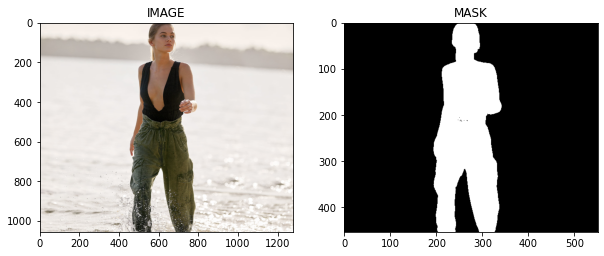

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [7]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 123)

# Task 3 : Augmentation Functions

In [8]:
def get_train_augs():
    return Compose([
        Resize(IMG_SIZE, IMG_SIZE),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return Compose([
        Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [9]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        image = cv2.imread(row['images'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row['masks'], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        image = torch.Tensor(image) / 255.
        mask = torch.round(torch.Tensor(mask) / 255.)

        return image, mask

In [10]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [11]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


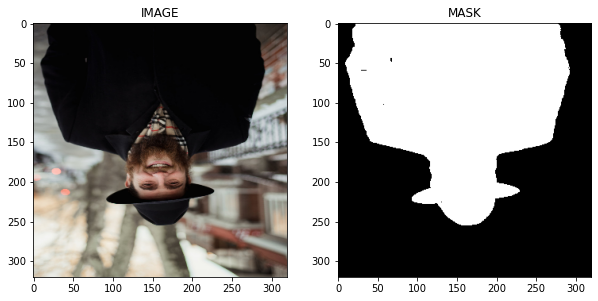

In [12]:
index = 2
image, mask = trainset[index]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [36]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 29
total no. of batches in validloader : 8


In [38]:
image, mask = next(iter(trainloader))
print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([8, 3, 320, 320])
One batch mask shape : torch.Size([8, 1, 320, 320])


# Task 6 : Create Segmentation Model

In [32]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self, images, masks = None):
        logits = self.arc(images)
        
        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [33]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function

In [66]:
def train_model(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    
    for data in tqdm(data_loader, color='red'):
        
        images, masks = data
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        accuracy = model.accuracy(logits, masks)
        total_loss += loss.item()
    
    return total_loss / len(data_loader), accuracy

def eval_model(data_loader, model):
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            accuracy = model.accuracy(logits, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader), accuracy

# Task 8 : Train Model

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [65]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss, train_acc = train_model(trainloader, model, optimizer)
    valid_loss, valid_acc = eval_model(validloader, model)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss
        
    print(f"Epoch : {i+1} \nTrain Accuracy : {train_acc} ----- Train loss : {train_loss} \nValid Accuracy : {valid_acc} ----- Valid loss : {valid_loss}")

  0%|                                                                                           | 0/29 [00:00<?, ?it/s]


AttributeError: 'SegmentationModel' object has no attribute 'accuracy'

# Task 9 : Inference

In [62]:
index = 21

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[index]

logits_mask = model(image.to(DEVICE).unsqueeze(0))

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

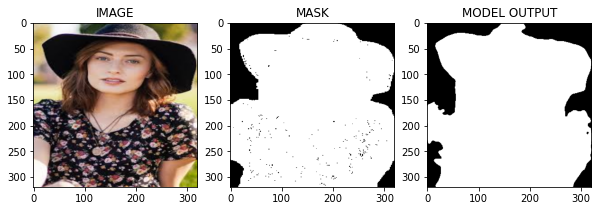

In [63]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))